# Morning: Introduction to Time Series Analysis

First thing we do is remove any previous workspace and load the required packages

In [1]:
rm(list=ls())      #remove data from workspace
library(nlme)      #pacakge to fit statistical models with autocorrelation

## Is there a trend?

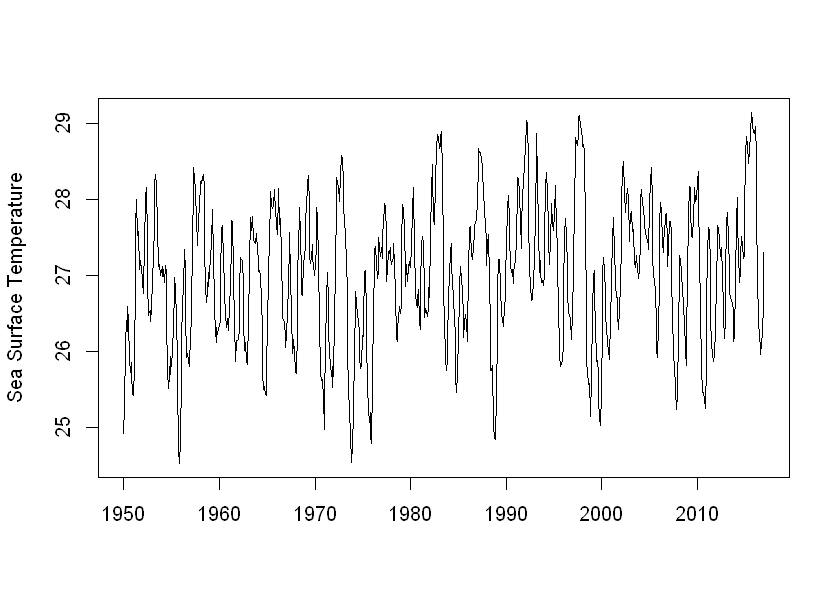

In [2]:
sst <- read.table('http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt',header=TRUE)  #read monitoring data published to NOAA website
y   <- sst$TOTAL                                          #define vector for SST measurement
t   <- seq(1950,2017,length.out=nrow(sst))                #define time variable [float vector]
options(repr.plot.width=7, repr.plot.height=5)            #define dimensions of jupyter plot window
plot(t,y,type='l',xlab='',ylab='Sea Surface Temperature') #make plot as a line

In [3]:
summary(lm(y ~ t))   #return summary of the fitted model object lm(y~t)


Call:
lm(formula = y ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4020 -0.6441  0.0608  0.6246  1.9709 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.688845   3.290339   3.249  0.00121 ** 
t            0.008230   0.001659   4.961 8.55e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9125 on 805 degrees of freedom
Multiple R-squared:  0.02967,	Adjusted R-squared:  0.02846 
F-statistic: 24.61 on 1 and 805 DF,  p-value: 8.551e-07


## Generate sample realizations
The code below generates sample realizations of the stochastic process defined by the ``rnorm()`` command. The ``rnorm(n,mean,sd)`` takes the size of the realization as its first arguement, the mean of the normal distribution as its second, and the standard deviation as its third.

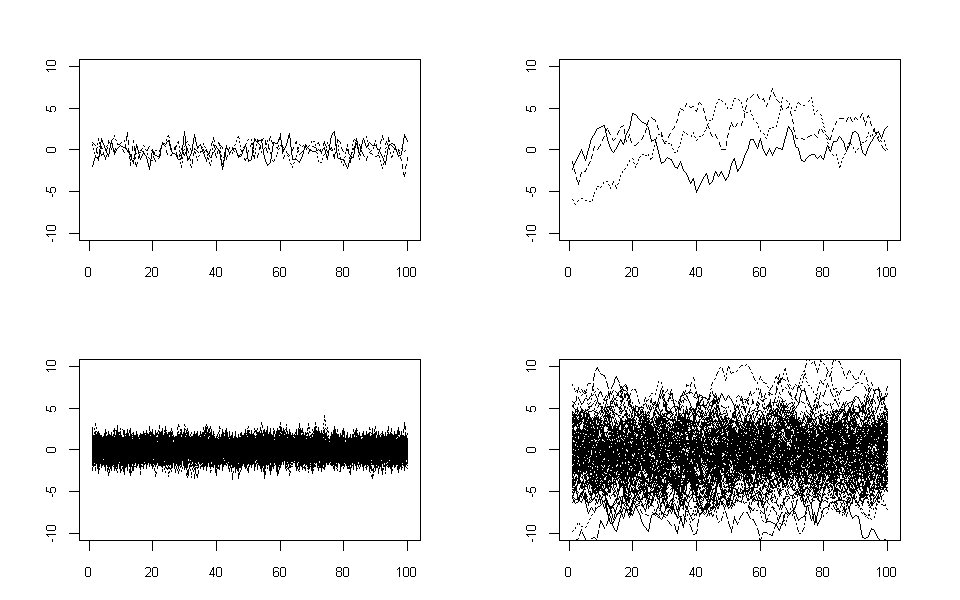

In [4]:
options(repr.plot.width=8, repr.plot.height=5)      #set dimensions of jupyter plot window
par(mfrow=c(2,2),mar=c(3,4,3,3),cex.axis=0.8)       #set matrix layout c(2,2), margin width, and axis label size of R plots
	matplot(replicate(3,rnorm(100)),type='l',                     #purely random process; 3 realizations; matplot() plots columns of matrix simultaneouly, replicate() generates matrix with the given sample realizations as its columns
            ylab='',xlab='',col='black',ylim=c(-10,10))     
	matplot(replicate(3,arima.sim(100,model=list(ar=0.95))),      #autoregressive model with autoregressive coefficient 0.95; 3 realizations
            type='l',ylab='',xlab='',col='black',ylim=c(-10,10))
	matplot(replicate(100,rnorm(100)),                            #purely random process; 100 realizations
            type='l',ylab='',xlab='',col='black',ylim=c(-10,10))
	matplot(replicate(100,arima.sim(100,model=list(ar=0.95))),    #autoregressive; 100 realizations
            type='l',ylab='',xlab='',col='black',ylim=c(-10,10))


## The autocorrelation function

In [5]:
sst <- read.table('http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt',header=TRUE) #download sea surface temperature monitoring data from NOAA website
y   <- sst$TOTAL      #extract the observed sst and store it as variable y
n   <- length(y)      #extract the number of observations

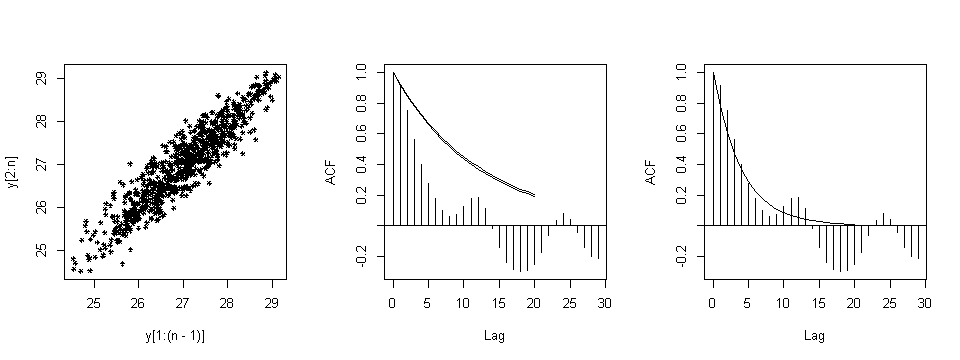

In [6]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))                                                  #set the plot matrix layout c(1,2)
plot(y[1:(n-1)],y[2:n],pch=8,cex=0.5)                              #scatterplot with values lagged by 1 unit
alpha_hat1 <- cor(y[1:(n-1)],y[2:n])                               #the correlation coefficient between lagged values
alpha_hat2 <- summary(lm(y[2:n] ~ y[1:(n-1)]))$coefficients[2,1]   #the linear slope between lagged values
acf(y,demean=TRUE,ci=0,main='',type='correlation')                 #estimate and plot the empirical autocorrelation function
lines(seq(0,20),alpha_hat1^seq(0,20))                              #add line for threoretical acf using correlation coefficient
lines(seq(0,20),alpha_hat2^seq(0,20))                              #add line for threoretical acf using slope
acf(y,demean=TRUE,ci=0,main='',type='correlation')                 #estimate and plot the empirical autocorrelation function
lines(seq(0,20),0.78^seq(0,20))                                    #plot the optimized autocorrelation function (more info below)

## Generate various time series structures

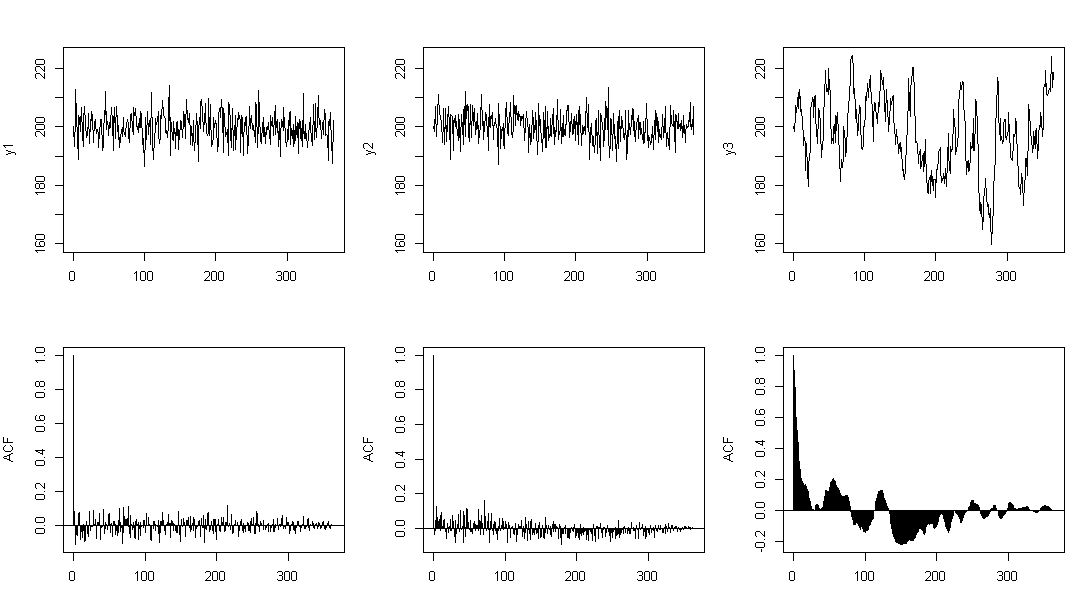

In [7]:
rm(list=ls())
y0       <- 20       #intercept value
a        <- 0.9      #autocorrelation/autoregressive parameter
s        <- 5        #standard deviation of the random increments
b        <- 1        #amplitude of the seasonal cycle
nyrs     <- 1        #number of years in the simulation
T        <- nyrs*365 #number of days
f        <- seq(0,2*pi*nyrs,length.out=T)  #nyrs cycles over the number of days T [radians]
sinf     <- sin(f)                         #sine wave
y1=y2=y3 <- 200                            #initial values

for(i in 2:T){
    y1t1 <- y1[1] + rnorm(1,0,s)                         #'purely random process' (PRP)
    y2t1 <- y2[1] + rnorm(1,0,s) + b*sinf[i]             #PRP with seasonal component
    y3t1 <- y0    + rnorm(1,0,s) + b*sinf[i] + a*y3[i-1] #PRP with seasonal component and autocorrelation
    y1 <- c(y1,y1t1)                                     #extend the time series with new values
    y2 <- c(y2,y2t1)
    y3 <- c(y3,y3t1)
}

options(repr.plot.width=9, repr.plot.height=5)
par(mfrow=c(2,3),mar=c(3,4,3,1))
plot(y1,type='l',ylim=c(range(c(y1,y2,y3))))     #plot each time series with yaxes set by the range of all values
plot(y2,type='l',ylim=c(range(c(y1,y2,y3))))
plot(y3,type='l',ylim=c(range(c(y1,y2,y3))))
acf(y1,lag.max=T,ci=0,main='')                   #estimate and plot the empirical autocorrelation function
acf(y2,lag.max=T,ci=0,main='')
acf(y3,lag.max=T,ci=0,main='')


## Simple trend analysis with autocorrelation

In [8]:
sst <- read.table('http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt',header=TRUE)  #extract observed sea surface temperature from the NOAA website
y   <- sst$TOTAL                                #extract the observed sea surface temperature
t   <- seq(1950,2017,length.out=nrow(sst))      #define time variable with same number of years as the data 

In [9]:
summary(gls(y ~ t, correlation=corAR1()), method='ML')   #fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. Specify method='ML' to fit exact maximum likelihood  

Generalized least squares fit by REML
  Model: y ~ t 
  Data: NULL 
       AIC      BIC    logLik
  637.1089 655.8723 -314.5545

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9272067 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 5.816964 16.795079 0.3463493  0.7292
t           0.010672  0.008467 1.2603950  0.2079

 Correlation: 
  (Intr)
t -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.4783251 -0.6540165  0.1030884  0.6908156  2.0707585 

Residual standard error: 0.9484359 
Degrees of freedom: 807 total; 805 residual

# -----------MORNING BREAK-------------------------------------------

## Analysis of Orange Country ozone time series
## Simple trend analysis

In [10]:
d <- read.csv('D:/Dropbox/Teaching/Bayes/DSI/Environmental_Stats_with_Stan/Data/ozone_orange.csv',stringsAsFactors=FALSE)
d <- d[d$year!=2016,]                                     #incomplete chunk of observation, remove for simplicity, using only data before 2016
y1 <- d$ozone                                             #extract the daily mean ozone variable
t <- seq(min(d$year),max(d$year),length.out=length(y1))   #define time variable

In [12]:
summary(gls(y1 ~ t, correlation=corAR1(), method='ML'))   #display the summary of a fitted regression with autoregressive covariance matrix

Generalized least squares fit by maximum likelihood
  Model: y1 ~ t 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t           -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
  (Intr)
t -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual

## Harmonic regression

In [13]:
nyrs  	  <- max(d$year)-min(d$year)              #number of seasonal cycles [years]
f         <- seq(0,2*pi*nyrs,length.out=nrow(d))  #nyrs cycles over the length of the time series [radians]
	sinf  <- sin(f)                               #sine wave of f
	cosf  <- cos(f)                               #cose wave of f

In [14]:
summary(gls(y1 ~ sinf + cosf,correlation=corAR1(), method='ML'))   #fit regression with seasonal component and first order autoregressive covariance matrix

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual

## Time series decomposition

In [15]:
fit     <- gls(y1 ~ sinf + cosf + t,correlation=corAR1(), method='ML')  #store the model object from the fit above
k_hat   <- summary(fit)$t                                               #extract fitted regression coefficients
phi_hat <- coef(fit$model$corStruct,unconstrained=FALSE)                #extract fitted autoregressive parameter
e <- residuals(fit,'response')                                          #extract 'raw' residuals (yi - ypred) 
n <- length(e)                        

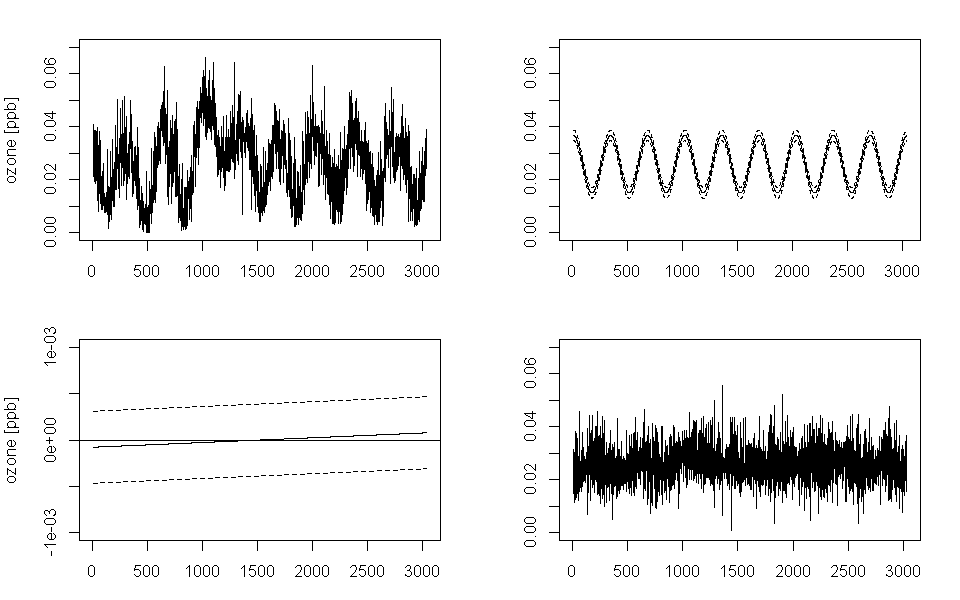

In [16]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(2,2),mar=c(3,4,2,2))
plot(y1,type='l',ylim=c(0,0.07),ylab='ozone [ppb]')                       #plot the data

f_hat <- mean(y1) + k_hat[2,1]*sinf + k_hat[3,1]*cosf                     #fitted seasonal cycle
plot(f_hat,type='l',ylim=c(0,0.07),ylab='')                               #plot fitted seasonal cycle
	lines(f_hat + 2*sqrt(k_hat[2,2]^2 + k_hat[3,2]^2),lty=2)              #add 95% CIs (upper)
	lines(f_hat - 2*sqrt(k_hat[2,2]^2 + k_hat[3,2]^2),lty=2)              #add 95% CIs (lower)

t_hat <- k_hat[1,1] + k_hat[4,1]*t                                        #fitted trend
t_hat <- t_hat - mean(t_hat)                                              #normalize to the zero-line   
plot(t_hat, type='l',ylim=c(-0.001,0.001),ylab='ozone [ppb]')             #plot the values
	lines(t_hat + 2*k_hat[4,2],lty=2)                                     #upper 95% CI
	lines(t_hat - 2*k_hat[4,2],lty=2)                                     #lower 95% CI
	abline(h=0)                                                           #add the zero-line
ear <- e[2:n]-phi_hat*e[1:(n-1)]                                          #subtract the autoregression
plot(mean(y1)+ear,type='l',ylim=c(0,0.07),ylab='')                        #plot the residuals

## Time series regression

In [17]:
x1  <- d$temp      #extract temperature variable
x2  <- d$windsp    #extract wind speed
x3  <- d$winddir   #extract wind direction
fitx1   <- gls(y1 ~ sinf + cosf + x1,correlation=corAR1(), method='ML')    #fit regression with seasonal terms, one input, with autoregressive correlation matrix  
summary(fitx1)     #display summary of the fitted model

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error   t-value p-value
(Intercept) 0.024437725 0.0021696121 11.263638  0.0000
sinf        0.000793210 0.0007218835  1.098807  0.2719
cosf        0.010728155 0.0007200955 14.898239  0.0000
x1          0.000022837 0.0000331050  0.689847  0.4903

 Correlation: 
     (Intr) sinf   cosf  
sinf  0.193              
cosf  0.192  0.039       
x1   -0.973 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual

In [18]:
fitx123 <- gls(y1 ~ sinf + cosf + x1 + x2 + x2,correlation=corAR1(), method='ML')   #fit linear regression with seasonal cycle and three independent variables; fit via maximum likelihood method='ML'
summary(fitx123)                                                                    #display the summary of the model

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 + x2 + x2 
  Data: NULL 
        AIC      BIC   logLik
  -22591.43 -22549.3 11302.71

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7927514 

Coefficients:
                   Value    Std.Error   t-value p-value
(Intercept)  0.023798677 0.0020061350 11.862949  0.0000
sinf         0.001740802 0.0007343941  2.370392  0.0178
cosf         0.010721061 0.0007314016 14.658241  0.0000
x1          -0.000113194 0.0000308444 -3.669846  0.0002
x2           0.002709782 0.0001109271 24.428482  0.0000

 Correlation: 
     (Intr) sinf   cosf   x1    
sinf  0.171                     
cosf  0.172  0.032              
x1   -0.949 -0.185 -0.176       
x2   -0.026  0.050 -0.003 -0.167

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-3.09073184 -0.71984867 -0.06315983  0.67064718  3.69791739 

Residual standard error: 0.009578996 
Degrees of freedom: 3035

## Model Selection

In [19]:
data.frame(
    model= c('fitx1','fitx123'),                                       #model labels
    R2   = c(cor(y1,predict(fitx1))^2, cor(y1,predict(fitx123))^2),    #percent varation explained by the predictions
    BIC  = c(summary(fitx1)$BIC,       summary(fitx123)$BIC),          #Bayesian information criterion
    k    = c(summary(fitx1)$dims$p,    summary(fitx123)$dims$p))       #number of parameters in the models


model,R2,BIC,k
fitx1,0.3740440,-22015.87,4
fitx123,0.4237032,-22549.30,5


In [ ]:
par(mfrow=c(2,2))
plot(y1,pch=8,cex=0.7)
plot(residuals(fitx1, 'response'),pch=8,cex=0.7,ylab='raw residuals')        #'raw' residuals
plot(residuals(fitx1, 'pearson'),pch=8,cex=0.7,ylab='standardized residuals')         #normalized to have unit variance
plot(residuals(fitx1, 'normalized'),pch=8,cex=0.7,ylab='residuals after autocorrelation')      #residuals after removing the autocorrelation